# Spaceship Titanic

https://www.kaggle.com/competitions/spaceship-titanic/overview

**Attribute Descriptions**:   

* **PassengerId** - A unique Id for each passenger. Each Id takes the form ```gggg_pp``` where gggg indicates a group the passenger is travelling with and ```pp``` is their number within the group. People in a group are often family members, but not always.   
* **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.   
* **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.   
* **Cabin** - The cabin number where the passenger is staying. Takes the form ```deck/num/side```, where side can be either ```P``` for Port or ```S``` for Starboard.   
* **Destination** - The planet the passenger will be debarking to.   
* **Age** - The age of the passenger.   
* **VIP** - Whether the passenger has paid for special VIP service during the voyage.   
* **RoomService**, **FoodCourt**, **ShoppingMall**, **Spa**, **VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.   
* **Name** - The first and last names of the passenger.   

**Response Variable**

* **Transported** - Whether the passenger was transported to another dimension. This is the **target**, the column you are trying to predict.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare dataset

In [15]:
# Get data
df_train = pd.read_csv(r'data/train.csv')
df_test = pd.read_csv(r'data/test.csv')
print(f"Training dataset: {df_train.shape}, testing dataset: {df_test.shape}")

Training dataset: (8693, 14), testing dataset: (4277, 13)


### Data Overview

In [16]:
# Overview
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [17]:
# missing value portion
print(df_train.isna().sum()/df_train.count())
print(f"Maximal missing value portion: {(df_train.isna().sum()/df_train.count()).max() * 100}%")

PassengerId     0.000000
HomePlanet      0.023669
CryoSleep       0.025602
Cabin           0.023428
Destination     0.021384
Age             0.021024
VIP             0.023910
RoomService     0.021264
FoodCourt       0.021504
ShoppingMall    0.024514
Spa             0.021504
VRDeck          0.022105
Name            0.023549
Transported     0.000000
dtype: float64
Maximal missing value portion: 2.560169891458235%


In [18]:
# description of numeric features
df_train_num = df_train.select_dtypes(include=[float, int])

df_train_num.describe().T\
    .join(pd.DataFrame(df_train_num.skew(), columns=['Skew']))\
    .join(pd.DataFrame(df_train_num.kurtosis(), columns=['Kurtosis']))\
    .join(pd.DataFrame(df_train_num.std()/df_train_num.mean(), columns=['Coefficient of Variation']))


,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis,Coefficient of Variation
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0,0.419097,0.101933,0.502604
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0,6.333014,65.273802,2.967309
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0,7.102228,73.307230,3.517942
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0,12.627562,328.870913,3.480685
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0,7.636020,81.202110,3.653371
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0,7.819732,86.011186,3.758239


From the skewness, kurtosis reveals that, with the exception of Age, all the other numeric features show a pronounced right-skewed distribution, asymmetric and remarkably narrow bell curve. Especially for ShoppingMall variable. These long right-tail and narrow bell pattern indicate that these features have substantial outliers. From the quantiles of these features we can see, most passengers didn't spend any money on the ship, but a few spend a lot. These distributions are displayed as below. 

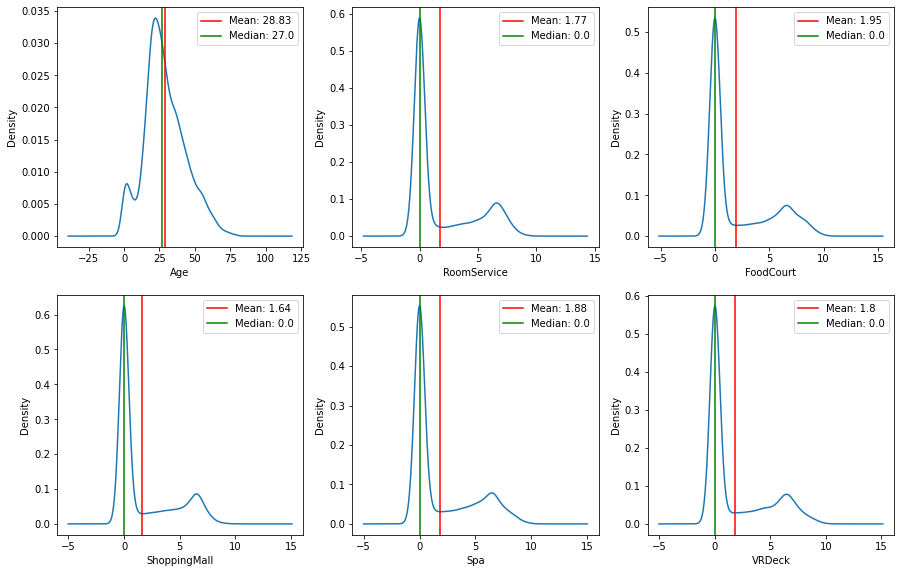

In [6]:
# Plot feature distribution
df_plot = np.log(df_train_num+1)

features = df_plot.columns
n = int(np.ceil(np.sqrt(len(features))))
fig, ax = plt.subplots(n, n, figsize=(5*n, 5*n))

for i in range(len(features)):
    mean = df_plot[features[i]].mean()
    median = df_plot[features[i]].median()
    
    if features[i] != 'Age':
        df_plot[features[i]].plot(kind='density', ax=ax[i//n][i%n], label='_nolegend_')

    else:
        mean = df_train_num[features[i]].mean()
        median = df_train_num[features[i]].median()

        df_train_num[features[i]].plot(kind='density', ax=ax[i//n][i%n], label='_nolegend_')
        
    ax[i//n][i%n].axvline(mean, color='r', label=f'Mean: {round(mean, 2)}')
    ax[i//n][i%n].axvline(median, color='g', label=f"Median: {round(median, 2)}")

    ax[i//n][i%n].set_xlabel(features[i])
    ax[i//n][i%n].legend()
# Remove extra subplots
if n > 1:
    for j in range(i+1, n**2):
        fig.delaxes(ax[j//n][j%n])
else:
    for j in range(i+1, n):
        fig.delaxes(ax[j])
        
plt.show()

In [19]:
# description of categorical features
df_train_cat = df_train.select_dtypes(include=[object])

df_train_cat.describe().T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


  * Only a very few passengers are VIP


**Feature Analysis**
1. Classify these right-skewed features to 0 and not 0
2. Did CryoSleep passenger consume?
3. Classify based on the cost of passengers.

In [22]:
df_train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

Conclusions of data
1. As the maximal missing value portion of feature is only 2.56%, we can remove all the missing values in the dataset.
2. log transormation for righ-skewed features, as most the value is 0, using plus 1 transform.
3. 

### Process Data

In [46]:
pd.concat([df_plot, df_train[['Transported']]], axis=1)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,3.688879,0.000000,0.000000,0.000000,0.000000,0.000000,False
1,3.218876,4.700480,2.302585,3.258097,6.309918,3.806662,True
2,4.077537,3.784190,8.182280,0.000000,8.812248,3.912023,False
3,3.526361,0.000000,7.157735,5.918894,8.110728,5.267858,False
4,2.833213,5.717028,4.262680,5.023881,6.338594,1.098612,True
...,...,...,...,...,...,...,...
8688,3.737670,0.000000,8.827615,0.000000,7.404888,4.317488,False
8689,2.944439,0.000000,0.000000,0.000000,0.000000,0.000000,False
8690,3.295837,0.000000,0.000000,7.535297,0.693147,0.000000,True
8691,3.496508,0.000000,6.956545,0.000000,5.869297,8.082093,False


In [33]:
df_train['CryoSleep'].value_counts()/df_train['CryoSleep'].count()

CryoSleep
False    0.641694
True     0.358306
Name: count, dtype: float64

In [37]:
df_train.groupby('Transported')['CryoSleep'].value_counts()/df_train['CryoSleep'].count()

Transported  CryoSleep
False        False        0.430628
             True         0.065361
True         True         0.292945
             False        0.211067
Name: count, dtype: float64

1. CrytoSleep = True, transported probabiliti increased 1/3

In [62]:
groupby('Transported')['Transported'].value_counts().plot(kind='barh')

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

<AxesSubplot:ylabel='FoodCourt,Transported'>

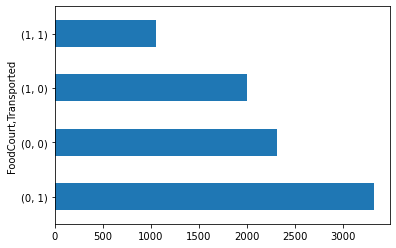

In [22]:
(df_train[list(df_train.select_dtypes(include=[int, float]).columns) + ['Transported']] > 0).astype(int).groupby('FoodCourt')['Transported'].value_counts().plot(kind='barh')